In [1]:
import torch, math
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from nets import Qnetn, MLP_NN
from taskmeta import SINTASK, SINTASK2, SINTASK3, SIN_xlow, SIN_xhigh


device, dtype = 'cpu', torch.float32
def tensor(data, rgrad=False):
    return torch.tensor(data, device=device, dtype=dtype, requires_grad=rgrad)

GRS = 12
RNG = np.random.default_rng(GRS)
randseed = lambda : RNG.integers(1, 10_000)
xl, xh = SIN_xlow, SIN_xhigh

HH = [1, 25, 25, 25, 1]
lossF = lambda pp, yy: 0.5 * (pp-yy)**2
lossM = lambda pp, yy: torch.sum(0.5 * (pp - yy) ** 2) 

NN = lambda : MLP_NN(HH, device, dtype, actF=nn.ReLU, seed=randseed())
NP = lambda ext_params: MLP_NN(ext_params, device, dtype, actF=nn.ReLU, seed=randseed(), from_param=True)

# Meta Learning

In [2]:
taskerL = [
    SINTASK2((7, 3), seed=randseed()),
    SINTASK2((6, 2), seed=randseed()),
    SINTASK2((5, 1), seed=randseed()),
    SINTASK2((4, 0), seed=randseed()),
    SINTASK2((3, -1), seed=randseed()),
] 
tasker = taskerL[0]

# algorithm

In [3]:
inner_epochs =  1000
inner_lr =      0.001
train_K =       8
P = print

In [4]:
# load theta
model = NN()
#model.load_external('meta_pie') #<---- comment this to not use meta pie
model.info(show_vals=True)

--------------------------
~ N_LAYERS:[4]
~ D_TYPE:[torch.float32]
~ DEV:[cpu]
--------------------------
--> Weights[0]:: Params[25] of Shape[torch.Size([25, 1])]
 ~--> [PARAMETER TENSOR]: tensor([[ 4.0752e-02],
        [-8.0139e-02],
        [-2.0934e-03],
        [ 9.1835e-02],
        [-6.5284e-05],
        [ 5.8189e-02],
        [-8.6809e-02],
        [ 2.3397e-02],
        [ 6.8264e-02],
        [-1.3586e-02],
        [ 2.6145e-02],
        [-1.7595e-02],
        [ 3.8888e-02],
        [-8.4653e-02],
        [ 2.8353e-02],
        [-5.0440e-02],
        [-5.0463e-02],
        [-2.3697e-02],
        [-6.8030e-02],
        [-3.7875e-02],
        [-2.6412e-02],
        [ 5.6413e-04],
        [-8.0990e-02],
        [-4.2174e-03],
        [-5.4436e-02]], requires_grad=True)
--> Bias[0]:: Params[25] of Shape[torch.Size([25])]
 ~--> [PARAMETER TENSOR]: tensor([-0.0140, -0.0385,  0.0818, -0.0299, -0.0257,  0.0169, -0.0935,  0.0139,
         0.0154,  0.0660, -0.0231, -0.0817,  0.0506,  0.

1376

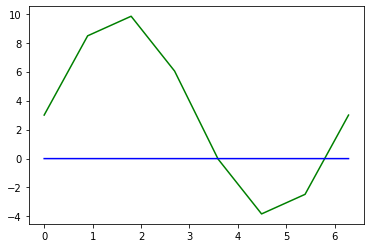

In [5]:
db =tasker.space(train_K)
bx = torch.tensor(np.expand_dims(db[ :, 0 ],axis=-1), dtype=torch.float32)
by = torch.tensor(np.expand_dims(db[ :, 1 ],axis=-1), dtype=torch.float32)
bp = []
with torch.no_grad():
    pred=model.forward(bx)
    plt.plot(db[:,0], db[:,1], color='green')
    plt.plot(db[:,0], pred, color='blue')


# training

	 Loss: 192.74098205566406
	 Loss: 146.51731872558594
	 Loss: 113.73540496826172
	 Loss: 71.35035705566406
	 Loss: 83.33206939697266
	 Loss: 143.5194091796875
	 Loss: 75.93760681152344
	 Loss: 43.44797897338867
	 Loss: 83.37104034423828
	 Loss: 75.56061553955078
	 Loss: 162.35531616210938
	 Loss: 145.99652099609375
	 Loss: 66.95308685302734
	 Loss: 66.68871307373047
	 Loss: 103.15310668945312
	 Loss: 231.77371215820312
	 Loss: 152.58824157714844
	 Loss: 135.34481811523438
	 Loss: 38.98521423339844
	 Loss: 113.81452178955078
	 Loss: 33.30775833129883
	 Loss: 106.8727035522461
	 Loss: 90.73588562011719
	 Loss: 123.09916687011719
	 Loss: 79.09929656982422
	 Loss: 129.728271484375
	 Loss: 140.06600952148438
	 Loss: 96.0939712524414
	 Loss: 64.88751220703125
	 Loss: 60.208553314208984
	 Loss: 115.21101379394531
	 Loss: 144.1961669921875
	 Loss: 127.36264038085938
	 Loss: 124.39498901367188
	 Loss: 53.0231819152832
	 Loss: 69.34066009521484
	 Loss: 131.57510375976562
	 Loss: 99.8589096069336

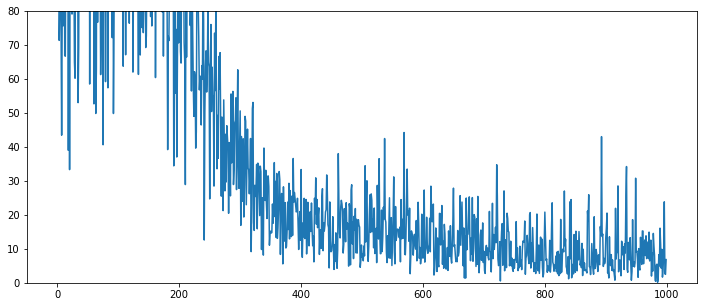

In [6]:


loss_hist=[]
for inner_epoch in range(inner_epochs):

    #P('# 5: sample train_K data points', train_K)
    train_db =tasker.sample(train_K)
    batch_x = torch.tensor(np.expand_dims(train_db[ :, 0 ],axis=-1), dtype=torch.float32)
    batch_y = torch.tensor(np.expand_dims(train_db[ :, 1 ],axis=-1), dtype=torch.float32)

    #P('# 6: evaluate grad_theta(loss)')
    model.zero_grad()
    pred = model.forward(batch_x)
    loss =  lossM(pred, batch_y) #torch.sum((pred - batch_y) ** 2) 
    
    loss_hist.append(loss.item())
    P('\t Loss:', loss_hist[-1])
    #loss.backward(create_graph=True)
    grads = torch.autograd.grad(loss, model.parameters, create_graph=False)

    #P('# 7: compute adapted paramters with grad descent')
    with torch.no_grad():
        for t_param, grad in zip(model.parameters, grads):
            t_param -= inner_lr * grad

plt.figure(figsize=(12,5))
plt.ylim(0,80)
plt.plot(loss_hist)
plt.show()

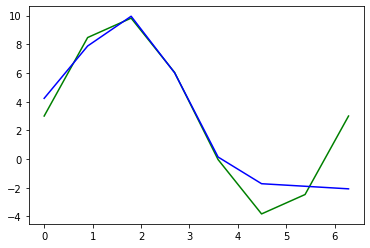

In [7]:
db =tasker.space(train_K)
bx = torch.tensor(np.expand_dims(db[ :, 0 ],axis=-1), dtype=torch.float32)
by = torch.tensor(np.expand_dims(db[ :, 1 ],axis=-1), dtype=torch.float32)
bp = []
with torch.no_grad():
    pred=model.forward(bx)
    plt.plot(db[:,0], db[:,1], color='green')
    plt.plot(db[:,0], pred, color='blue')
